<a href="https://colab.research.google.com/github/veenachowdaryayyannagari/watermarking/blob/main/watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
HYPERPARAMETERS
"""
watermark_shape = (32, 32, 1)
cover_image_shape = (128, 128, 3)
learning_rate_dec = 0.001
learning_rate_enc = 0.001
lambda_1 = 93
lambda_2 = 1.2
lambda_3 = 0.00001
batch_size = 8
base_path = "/Users/veenaayyannagari/Desktop/major project/ds/"
max_val = 1.0
steps_per_epoch = 250
threshold_value = 0.5
N = 8

In [ ]:
%pip install kagglehub
"""import kagglehub

# Download latest version
path = kagglehub.dataset_download("sameer89/imagenet-binary-cifarfor-watermarking-networks")

print("Path to dataset files:", path)"""

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("sameer89/imagenet-binary-cifarfor-watermarking-networks")\n\nprint("Path to dataset files:", path)'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
#%pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
addict                       2.4.0
altair                       5.0.1
anyio                        3.6.2
appnope                      0.1.3
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        22.2.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.1
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.2.0
click                        8.1.6
coloredlogs                  15.0.1
comm                         0.1.3
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.6.7
de

In [ ]:
"""
LIBRARIES
"""
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import constant
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow_addons as tfa
import random
import time
from tqdm.notebook import tqdm

In [ ]:
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.18.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
seed = random.randint(1, 10**4)
print(seed)

2750


In [ ]:
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
# model = tf.keras.models.load_model("/kaggle/working/7Nov/25.h5")

In [ ]:
"""
ARCHITECTURE
"""


def Convolution_Block(input_tensor):
    # Branch 1
    branch1 = Conv2D(32, (1, 1), padding='same', activation='relu')(input_tensor)

    # Branch 2
    branch2 = Conv2D(32, (1, 1), padding='same', activation='relu')(input_tensor)
    branch2 = Conv2D(32, (3, 3), padding='same', activation='relu')(branch2)

    # Branch 3
    branch3 = Conv2D(32, (1, 1), padding='same', activation='relu')(input_tensor)
    branch3 = Conv2D(32, (3, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(32, (3, 3), padding='same', activation='relu')(branch3)

    # Concatenate the branches
    concat_output = Concatenate(axis=-1)([branch1, branch2, branch3])

    # Apply 1x1 convolution
    final_output = Conv2D(1, (1, 1), padding='same')(concat_output)
    # Add the original input to the output
    final_output = Add()([final_output, input_tensor])

    return final_output


# Model Flow

#------------------------------------------------------------------------------------------#
# First Large Block (Watermark Preprocessing) (Encoder mu-theta-1)

# Taking watermark input
watermark = Input(shape=(32, 32, 1))


conv_block_x2A = Convolution_Block(watermark)
conv_block_x2A = Convolution_Block(conv_block_x2A)


conv2d_1x1x24 = Conv2D(24, (1, 1), activation='relu')(conv_block_x2A)

conv_block_x2B = Convolution_Block(conv2d_1x1x24)
conv_block_x2B = Convolution_Block(conv_block_x2B)

conv2d_1x1x48 = Conv2D(48, (1, 1), activation='relu')(conv_block_x2B)  # outuput wfi

#------------------------------------------------------------------------------------------#

# Second Large Block (Input Preprocessing & watermark Concatenation) (Embedder sigma-theta-2)


cover_images = Input(shape=cover_image_shape)

# Cover Preprocessing

x = Convolution_Block(cover_images)
x = Convolution_Block(x)
x = Conv2D(6,(1,1), activation='relu')(x)
x = Convolution_Block(x)
x = Conv2D(3,(1,1), activation='relu')(x)
# Taking cover image input

reshaped_watermark = Reshape((128,128,3))(conv2d_1x1x48)

conv_block_x1A = Convolution_Block(reshaped_watermark)  # grab this for intermediate loss calculation


concatenated_output = Concatenate(axis=-1)([conv_block_x1A, x])
# concatenated_output = ConcatWithAttention(conv_block_x1A, cover_images)

conv_block_x1B = Convolution_Block(concatenated_output)

conv2d_1x1x3 = Conv2D(3, (1, 1), activation='relu')(conv_block_x1B)  # output mi


#------------------------------------------------------------------------------------------#

# Third Large Block (Fully Connected Dense Layer) (Invariance Introduction) (Channel Coding) (Invariance tau-theta-5)
invariance = Dense(N)
invariance_output = invariance(conv2d_1x1x3)
#------------------------------------------------------------------------------------------#

# Decoder

# Fourth Large Block (Extractor psi-theta-3)

conv_block_x2C = Convolution_Block(invariance_output)
conv_block_x2C = Convolution_Block(conv_block_x2C)

conv2d_1x1x3B = Conv2D(3, (1, 1))(conv_block_x2C)  # this is wfi*

#------------------------------------------------------------------------------------------#

# Fifth Large Block (Decoder gamma-theta-4)
conv2d_1x1x3B = Reshape((32,32,48))(conv2d_1x1x3B)

conv_block_x2D = Convolution_Block(conv2d_1x1x3B)
conv_block_x2D = Convolution_Block(conv_block_x2D)

conv2d_1x1x24B = Conv2D(24, (1, 1))(conv_block_x2D)

conv_block_x2E = Convolution_Block(conv2d_1x1x24B)
conv_block_x2E = Convolution_Block(conv_block_x2E)

conv2d_1x1x1 = Conv2D(1, (1, 1))(conv_block_x2E)  # This is the extracted watermark wi*
# Create the model
model = tf.keras.Model(inputs=[watermark, cover_images], outputs=[conv2d_1x1x1, conv2d_1x1x3, invariance_output])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 96)     │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 1)      │             97 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 1)      │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 32)     │             64 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 32)     │             64 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 32)     │             64 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 96)     │              0 │ conv2d_7[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_9[0][0],        │
│                           │                        │                │ conv2d_12[0][0]        │
├──────────────────────

 Total params: 443,805 (1.69 MB)

 Trainable params: 443,805 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""
DATA PREPARATION FOR TRAINING & TESTING
"""

# TRAINING DATA GENERATORS

training_cover = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    base_path + "train",
    classes=['cover'],
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode=None,
    shuffle=True
)
training_watermark = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    base_path + "train",
    classes=['mark'],
    target_size=(32, 32),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode=None,
    shuffle=True
)
# training_cover.seed = training_watermark.seed = seed

Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [ ]:
#%pip install scipy
import scipy

Training Started (~˘▾˘)~
Current Epoch 0.....


  0%|          | 0/250 [00:00<?, ?it/s]

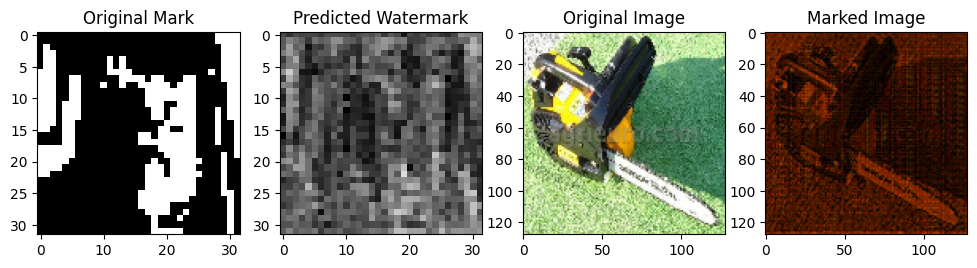

In [ ]:
 """
 TRAINING
 """
 print("Training Started (~˘▾˘)~")
 # PERFORMANCE METRICS
 def MSE(y_true, y_pred):
     return tf.reduce_mean(tf.square(y_true - y_pred))
 def PSNR(mse_val):
     return 10 * tf.math.log(max_val * max_val / mse_val) / tf.math.log(10.0)



 # TRAINING LOOP

 import time
 encoder_variables = []
 for i in range(90):
     encoder_variables.extend(model.layers[i].trainable_variables)
 for epoch in range(20):
     start_time = time.time()  # Record the start time for the current epoch
     print(f"Current Epoch {epoch}.....")
     total_mse1 = total_mse2 = reg_param = 0
     printed = False

     for step in tqdm(range(steps_per_epoch)):
         loss_1 = loss_2 = loss_3 = 0
         watermark_images, cover_images = training_watermark.next(), training_cover.next()
         with tf.GradientTape(persistent=True) as tape:
             tape.watch(encoder_variables)
             extracted_watermarks, watermarked_images, invariance_outputs = model([watermark_images, cover_images])

             if not printed:
                 printed = True
                 images = [watermark_images[0], extracted_watermarks[0], cover_images[0], watermarked_images[0]]
                 titles = ['Original Mark', 'Predicted Watermark', 'Original Image', 'Marked Image']
                 plt.figure(figsize=(12, 4))
                 for i in range(4):
                     plt.subplot(1, 4, i + 1)
                     plt.imshow(images[i], vmax=1.0, vmin=0.0, cmap='gray') if i in [0, 1] else plt.imshow(images[i])
                     plt.title(titles[i])
                 plt.show()

             loss_1 = MSE(cover_images, watermarked_images)
             loss_2 = MSE(extracted_watermarks, watermark_images)
             loss_3 = tf.reduce_sum(tf.square(tape.gradient(invariance_outputs, watermarked_images)))

             total_mse1 += loss_1
             total_mse2 += loss_2
             reg_param += loss_3
             total_loss = lambda_1 * loss_1 + lambda_2 * loss_2 + lambda_3 * loss_3

             gradientsEnc = tape.gradient(lambda_1 * loss_1, encoder_variables)
             gradientsDec = tape.gradient(total_loss, model.trainable_variables)
             optimizer.apply_gradients(zip(gradientsDec, model.trainable_variables))
             optimizer.apply_gradients(zip(gradientsEnc, encoder_variables))
             mse_1 = total_mse1 / steps_per_epoch
             mse_2 = total_mse2 / steps_per_epoch
             reg = reg_param / steps_per_epoch
             net_loss = lambda_1 * mse_1 + lambda_2 * mse_2 + lambda_3 * reg
         del tape

     end_time = time.time()  # Record the end time for the current epoch
     time_per_epoch = end_time - start_time  # Calculate time per epoch

     print(f"epoch {epoch}: \n PSNR = {PSNR(mse_1)} \n MSE_1 = {mse_1} \n MSE_2 = {mse_2} \n reg_param = {reg} \n Total Loss: = {net_loss} \n Time taken = {time_per_epoch} seconds")
     model.save(f"/Users/veenaayyannagari/Desktop/major project/{epoch}.h5")


In [ ]:
# Optimizer setup
optimizer = tf.keras.optimizers.legacy.Adam(0.001)
# Assuming learning_rate_dec is defined somewhere in your code
# optimizerB = tf.keras.optimizers.Adam(learning_rate_dec)
update_frequency = 5

# Define encoder variables to selectively train part of the model
encoder_variables = []
for i in range(90):
    encoder_variables.extend(model.layers[i].trainable_variables)

# Training loop
for epoch in range(50):
    # Other code for epoch setup...

    total_mse1 = total_mse2 = reg_param = 0

    # Initialize gradients accumulators
    accum_gradients_enc = [tf.zeros_like(var) for var in encoder_variables]
    accum_gradients_dec = [tf.zeros_like(var) for var in model.trainable_variables]

    for step in tqdm(range(steps_per_epoch)):
        # Other code for data loading and visualization...
        gradientsEnc = gradientsDec = None
        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape2:
                tape2.watch(encoder_variables)
                with tf.GradientTape() as tape3:
                    extracted_watermarks, watermarked_images, invariance_outputs = model([watermark_images, cover_images])

                    loss_1 = MSE(cover_images, watermarked_images)
                    loss_2 = MSE(extracted_watermarks, watermark_images)
                    loss_3 = tf.reduce_sum(tf.square(tape3.gradient(invariance_outputs, watermarked_images)))

                    total_mse1 += loss_1
                    total_mse2 += loss_2
                    reg_param += loss_3
                    total_loss = 1 * loss_2 + 1 * loss_3

                # Calculate gradients for encoder and decoder
                gradientsEnc = tape2.gradient(1 * loss_1, encoder_variables)
                gradientsDec = tape.gradient(total_loss, model.trainable_variables)

        # Accumulate gradients
        accum_gradients_enc = [acc_grad + grad for acc_grad, grad in zip(accum_gradients_enc, gradientsEnc)]
        accum_gradients_dec = [acc_grad + grad for acc_grad, grad in zip(accum_gradients_dec, gradientsDec)]

        # Optionally, update the model weights every N steps
        if (step + 1) % update_frequency == 0:
            optimizer.apply_gradients(zip(accum_gradients_enc, encoder_variables))
            optimizer.apply_gradients(zip(accum_gradients_dec, model.trainable_variables))

            # Reset gradient accumulators
            accum_gradients_enc = [tf.zeros_like(var) for var in encoder_variables]
            accum_gradients_dec = [tf.zeros_like(var) for var in model.trainable_variables]

    # Optionally, update the model weights for the remaining accumulated gradients
    optimizer.apply_gradients(zip(accum_gradients_enc, encoder_variables))
    optimizer.apply_gradients(zip(accum_gradients_dec, model.trainable_variables))

    # Calculate metrics and log information after each epoch...
    mse_1 = total_mse1 / steps_per_epoch
    mse_2 = total_mse2 / steps_per_epoch
    reg = reg_param / steps_per_epoch
    net_loss = lambda_1 * mse_1 + lambda_2 * mse_2 + lambda_3 * reg

    print(f"epoch {epoch}: \n PSNR = {PSNR(mse_1)} \n MSE_1 = {mse_1} \n MSE_2 = {mse_2} \n reg_param = {reg} \n Total Loss: = {net_loss}")



  0%|          | 0/250 [00:00<?, ?it/s]

epoch 0: 
 PSNR = 7.488731861114502 
 MSE_1 = 0.17828992009162903 
 MSE_2 = 2.1207456588745117 
 reg_param = 736292.1875 
 Total Loss: = 26.488780975341797


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


PermissionDeniedError: /kaggle; Read-only file system

In [ ]:
   model.save(f"/Users/veenaayyannagari/Desktop/major project/{epoch}.h5")

In [ ]:
# # """
# # TRAINING
# # """
# # print("Training Started (~˘▾˘)~")
# # PERFORMANCE METRICS
# def MSE(y_true, y_pred):
#     return tf.reduce_mean(tf.square(y_true - y_pred))
# def PSNR(mse_val):
#     return 10 * tf.math.log(max_val * max_val / mse_val) / tf.math.log(10.0)



# # TRAINING LOOP
# # learning_rate_enc = 0.01
# # clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.001,
# #     maximal_learning_rate=0.01,
# #     scale_fn=lambda x: 1/(2.**(x-1)),
# #     step_size=4 * steps_per_epoch
# # )
# # optimizer = tf.keras.optimizers.legacy.Adam(clr)
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate_enc)
# # optimizerB = Adam(learning_rate_dec)
# import time
# encoder_variables = []
# for i in range(90):
#     encoder_variables.extend(model.layers[i].trainable_variables)
# for epoch in range(80):
#     start_time = time.time()  # Record the start time for the current epoch
#     print(f"Current Epoch {epoch}.....")
#     total_mse1 = total_mse2 = reg_param = 0
#     printed = False

#     for step in tqdm(range(steps_per_epoch)):
#         loss_1 = loss_2 = loss_3 = 0
#         watermark_images, cover_images = training_watermark.next(), training_cover.next()
#         with tf.GradientTape() as tape:
#             with tf.GradientTape() as tape2:
#                 tape2.watch(encoder_variables)
#                 with tf.GradientTape() as tape3:
#                     extracted_watermarks, watermarked_images, invariance_outputs = model([watermark_images, cover_images])

#                     if not printed:
#                         printed = True
#                         images = [watermark_images[0], extracted_watermarks[0], cover_images[0], watermarked_images[0]]
#                         titles = ['Original Mark', 'Predicted Watermark', 'Original Image', 'Marked Image']
#                         plt.figure(figsize=(12, 4))
#                         for i in range(4):
#                             plt.subplot(1, 4, i + 1)
#                             plt.imshow(images[i], vmax=1.0, vmin=0.0, cmap='gray') if i in [0, 1] else plt.imshow(images[i])
#                             plt.title(titles[i])
#                         plt.show()

#                     loss_1 = MSE(cover_images, watermarked_images)
#                     loss_2 = MSE(extracted_watermarks, watermark_images)
#                     loss_3 = tf.reduce_sum(tf.square(tape3.gradient(invariance_outputs, watermarked_images)))

#                     total_mse1 += loss_1
#                     total_mse2 += loss_2
#                     reg_param += loss_3
#                     total_loss = 1.2 * loss_2 + 0.000001 * loss_3

#                     gradientsEnc = tape2.gradient(41*loss_1, encoder_variables)
#                     gradientsDec = tape.gradient(total_loss, model.trainable_variables)
# #                     print(gradientsEnc)
#                     optimizer.apply_gradients(zip(gradientsEnc, encoder_variables))
#                     optimizer.apply_gradients(zip(gradientsDec, model.trainable_variables))
#                     mse_1 = total_mse1 / steps_per_epoch
#                     mse_2 = total_mse2 / steps_per_epoch
#                     reg = reg_param / steps_per_epoch
#                     net_loss = lambda_1 * mse_1 + lambda_2 * mse_2 + lambda_3 * reg

#     end_time = time.time()  # Record the end time for the current epoch
#     time_per_epoch = end_time - start_time  # Calculate time per epoch

#     print(f"epoch {epoch}: \n PSNR = {PSNR(mse_1)} \n MSE_1 = {mse_1} \n MSE_2 = {mse_2} \n reg_param = {reg} \n Total Loss: = {net_loss} \n Time taken = {time_per_epoch} seconds")
#     model.save(f"/kaggle/working/10Nov/{epoch}.h5")


In [ ]:
"""
FINE TUNING
"""
def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))
def PSNR(mse_val):
    return 10 * tf.math.log(max_val * max_val / mse_val) / tf.math.log(10.0)
optimizer = Adam(0.001)
for epoch in range(25):
    start_time = time.time()  # Record the start time for the current epoch
    print(f"Current Epoch {epoch}.....")
    total_mse1 = total_mse2 = reg_param = 0
    printed = False
    for step in tqdm(range(steps_per_epoch)):
        watermark_images, cover_images = training_watermark.next(), training_cover.next()
        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape2:
                extracted_watermarks, watermarked_images, invariance_outputs = model([watermark_images, cover_images])

                if not printed:
                    printed = True
                    images = [watermark_images[0], extracted_watermarks[0], cover_images[0], watermarked_images[0]]
                    titles = ['Original Mark', 'Predicted Watermark', 'Original Image', 'Marked Image']
                    plt.figure(figsize=(12, 4))
                    for i in range(4):
                        plt.subplot(1, 4, i + 1)
                        plt.imshow(images[i], vmax=1.0, vmin=0.0, cmap='gray') if i in [0, 1] else plt.imshow(images[i])
                        plt.title(titles[i])
                    plt.show()

                loss_1 = MSE(cover_images, watermarked_images)
                loss_2 = MSE(extracted_watermarks, watermark_images)
                loss_3 = 0
                # Frobeinus Norm
                gd = tape2.gradient(invariance_outputs, watermarked_images)
                frobenius_param = tf.square(gd)
                loss_3 = tf.reduce_sum(frobenius_param)

            total_mse1 += loss_1
            total_mse2 += loss_2
            reg_param += loss_3
            l1 = 0.009 * tf.reduce_sum([tf.reduce_sum(tf.abs(weight)) for weight in model.trainable_variables])
            total_loss = lambda_1 * loss_1 + lambda_2 * loss_2 + lambda_3 * loss_3 + l1

        gradients = tape.gradient(total_loss, model.trainable_variables)

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        mse_1 = total_mse1 / steps_per_epoch
        mse_2 = total_mse2 / steps_per_epoch
        reg = reg_param / steps_per_epoch
        net_loss = lambda_1 * mse_1 + lambda_2 * mse_2 + lambda_3 * reg

    end_time = time.time()  # Record the end time for the current epoch
    time_per_epoch = end_time - start_time  # Calculate time per epoch

    print(f"epoch {epoch}: \n PSNR = {PSNR(mse_1)} \n MSE_1 = {mse_1} \n MSE_2 = {mse_2} \n reg_param = {reg} \n Total Loss: = {net_loss} \n Time taken = {time_per_epoch} seconds")
    model.save(f"/kaggle/working/7Nov/{epoch}.h5")

Current Epoch 0.....


  0%|          | 0/250 [00:00<?, ?it/s]

NameError: name 'scipy' is not defined

In [ ]:
"""
FINE TUNING
"""

def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))
def PSNR(mse_val):
    return 10 * tf.math.log(max_val * max_val / mse_val) / tf.math.log(10.0)
optimizer = Adam(0.001)
for epoch in range(21,50):
    start_time = time.time()  # Record the start time for the current epoch
    print(f"Current Epoch {epoch}.....")
    total_mse1 = total_mse2 = reg_param = 0
    printed = False
    for step in tqdm(range(steps_per_epoch)):
        watermark_images, cover_images = training_watermark.next(), training_cover.next()
        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape2:
                extracted_watermarks, watermarked_images, invariance_outputs = model([watermark_images, cover_images])

                if not printed:
                    printed = True
                    images = [watermark_images[0], extracted_watermarks[0], cover_images[0], watermarked_images[0]]
                    titles = ['Original Mark', 'Predicted Watermark', 'Original Image', 'Marked Image']
                    plt.figure(figsize=(12, 4))
                    for i in range(4):
                        plt.subplot(1, 4, i + 1)
                        plt.imshow(images[i], vmax=1.0, vmin=0.0, cmap='gray') if i in [0, 1] else plt.imshow(images[i])
                        plt.title(titles[i])
                    plt.show()

                loss_1 = MSE(cover_images, watermarked_images)
                loss_2 = MSE(extracted_watermarks, watermark_images)
                loss_3 = 0
                # Frobeinus Norm
                gd = tape2.gradient(invariance_outputs, watermarked_images)
                frobenius_param = tf.square(gd)
                loss_3 = tf.reduce_sum(frobenius_param)

            total_mse1 += loss_1
            total_mse2 += loss_2
            reg_param += loss_3
            total_loss = lambda_1 * loss_1 + lambda_2 * loss_2 + lambda_3 * loss_3

        gradients = tape.gradient(total_loss, model.trainable_variables)

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        mse_1 = total_mse1 / steps_per_epoch
        mse_2 = total_mse2 / steps_per_epoch
        reg = reg_param / steps_per_epoch
        net_loss = lambda_1 * mse_1 + lambda_2 * mse_2 + lambda_3 * reg

    end_time = time.time()  # Record the end time for the current epoch
    time_per_epoch = end_time - start_time  # Calculate time per epoch

    print(f"epoch {epoch}: \n PSNR = {PSNR(mse_1)} \n MSE_1 = {mse_1} \n MSE_2 = {mse_2} \n reg_param = {reg} \n Total Loss: = {net_loss} \n Time taken = {time_per_epoch} seconds")
    model.save(f"/kaggle/working/12Nov/{epoch}.h5")

Current Epoch 21.....


  0%|          | 0/250 [00:00<?, ?it/s]

NameError: name 'scipy' is not defined

In [ ]:
 testing_cover = ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
     "/kaggle/input/coco-2017-dataset/coco2017",
     classes=["test2017"],
     target_size=(128, 128),
     batch_size=batch_size,
     class_mode=None,
     shuffle=False,
 )
 testing_watermark = ImageDataGenerator(rescale=1.0 / 255.0).flow_from_directory(
     base_path + "test",
     classes=["mark"],
     target_size=(32, 32),
     color_mode="grayscale",
     batch_size=batch_size,
     class_mode=None,
     shuffle=False,
 )

In [ ]:
# # """
# # TESTING LOOP
# # """
# model = tf.keras.models.load_model('/kaggle/working/7Nov/18.h5')
# # print("Training Complete! initiating testing phase")
# m1 = m2 = 0
# for i in tqdm(range(80)):
#     input_data = [training_watermark.next(), training_cover.next()]
#     extracted_marks, marked_images,_ = model(input_data)
#     threshold_lambda = lambda x: tf.where(x >= 0.7, 1.0, 0.0)
#     extracted_marks = tf.map_fn(threshold_lambda, extracted_marks)
#     input_data[0] = tf.map_fn(threshold_lambda, input_data[0])
#     m1 += tf.reduce_mean(tf.square(input_data[1] - marked_images))
#     m2 += tf.reduce_mean(tf.square(input_data[0] - extracted_marks))
# print(PSNR(m1 / 80), m1 / 80, m2 / 80)

In [ ]:
# """
# ROBUSTNESS ANALYSIS
# """
# intensity = 90
# model = tf.keras.models.load_model('/kaggle/working/7Nov/42.h5')
# extractor = tf.keras.Model(inputs = model.layers[90].input, outputs = model.layers[-1].output)
# m2 = ber_total = 0
# n = 30
# def PSNR(mse_val, max_val=1.0):
#     return 10 * tf.math.log(max_val * max_val / mse_val) / tf.math.log(10.0)
# def salt_and_pepper_noise(image_tensor, salt_prob=0.025, pepper_prob=0.025):
#     salt_mask = tf.random.uniform(shape=image_tensor.shape[:3], dtype=tf.float32) < salt_prob
#     salt_mask = tf.expand_dims(salt_mask, axis=-1)
#     salt_mask = tf.concat([salt_mask,salt_mask,salt_mask], axis = -1)
#     pepper_mask = tf.random.uniform(shape=image_tensor.shape[:3], dtype=tf.float32) < pepper_prob
#     pepper_mask = tf.expand_dims(pepper_mask, axis=-1)
#     pepper_mask = tf.concat([pepper_mask]*3, axis = -1)
#     salt_noise = tf.zeros_like(image_tensor, dtype=tf.float32)
#     pepper_noise = tf.ones_like(image_tensor, dtype=tf.float32)
#     noisy_image = tf.where(salt_mask, salt_noise, image_tensor)
#     noisy_image = tf.where(pepper_mask, pepper_noise, noisy_image)
#     return noisy_image


# def attack(atk_name, intensity, marked_images):
#     if atk_name == 'gaussian':
#         # Gaussian noise attack
#         noise = tf.random.normal(shape=tf.shape(marked_images), mean=0.0, stddev=intensity)
#         attacked_images = marked_images + noise
#     elif atk_name == 'snp':
#         # Salt and pepper noise attack
#         attacked_images = salt_and_pepper_noise(marked_images, intensity/200, intensity/200)
#     elif atk_name == 'jpeg':
#         # JPEG compression attack (reduce quality)
#         attacked_images = tf.map_fn(lambda image: tf.image.adjust_jpeg_quality(image, intensity),marked_images, dtype = tf.float32)
#     elif atk_name == 'heq':
#         # Histogram equalization attack
#         marked_images = tf.clip_by_value(marked_images, 0.0, 1.0)
#         attacked_images = tfa.image.equalize(marked_images)
#     elif atk_name == 'gaussian_blur':
#         # Gaussian blur attack
#         attacked_images = tfa.image.gaussian_filter2d(marked_images, sigma=intensity)
#     elif atk_name == 'crop':
#         attacked_images = tf.map_fn(lambda image: tf.image.random_crop(image, size = (25, 25, 3)), marked_images)
#     else:
#         raise ValueError("Unsupported attack type: " + atk_name)
#     return attacked_images
# attacked_images = None
# for i in range(n):
#     input_data = [training_watermark.next(), training_cover.next()]
#     threshold_lambda = lambda x: tf.where(x >= 0.7, 1.0, 0.0)
#     input_data[0] = tf.map_fn(threshold_lambda, input_data[0])
#     _, marked_images,__ = model(input_data)
#     # Perform attack on marked_images, jpeg compression, salt and pepper noise, gaussian noise
#     attacked_images = attack('jpeg', intensity, marked_images) # atk_name can be 'gaussian', 'snp', 'jpeg'
#     extracted_marks = extractor(attacked_images)
#     extracted_marks = tf.map_fn(threshold_lambda, extracted_marks)
#     m2 += tf.reduce_mean(tf.square(input_data[0] - extracted_marks))

#     # Calculate BER
#     ber = 1.0 - tf.reduce_mean(tf.dtypes.cast(tf.equal(extracted_marks, input_data[0]), tf.float32))
#     ber_total += ber

# mse = m2 / n
# ber_percentage = (ber_total / n) * 100.0

# print("MSE:", mse)
# print("BER (%):", ber_percentage)


In [ ]:
# for i in range(20,30):
#     input_mark = input_data[0][i]
#     input_cover = input_data[1][i]
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 4, 1)
#     plt.imshow(input_mark, vmax=1.0,vmin=0.0,cmap='gray')
#     plt.title('Original Mark')

#     plt.subplot(1, 4, 2)
#     plt.imshow(extracted_marks[i], vmax=1.0,vmin=0.0,cmap='gray')
#     plt.title('Predicted Watermark')

#     plt.subplot(1, 4, 3)
#     plt.imshow(input_cover)
#     plt.title('Original Image')

#     plt.subplot(1, 4, 4)
#     plt.imshow(attacked_images[i])
#     plt.title('Marked Image')

#     plt.show()